<h1> ______________________________________ </h1>

<h1> Fiber panels with Kr38m decays simulation analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the 10000 MC Kr38m decay events simulated in a "realistic" fiber barrel to check if we're able to see the krypton signal with enough resolution. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 events. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] average absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


In [3]:
def dark_rate(dark25, dT, T):
    
#     dark25[Kcps] Dark rate at 25ºC
#     dT[ºC] Decay constant at which dark rate halves
#     T[ºC] Temperature

    exponent = (T - 25)/dT

    dark_rate = dark25*(2**exponent)
    
    return dark_rate

In [4]:
def noise(dark_rate, x_talk, t0, tf, dt, n_sensors):
    
#     dark_rate[Kcps] Number of dark pulses per second
#     x_talk[%] Cross talk probability (so the dark pulse is 2pe instead of 1pe)
#     t0[s] Measurements STARTING time
#     tf[s] Measurements ENDIND time
#     dt[s] Width of the time bin

    """
    Here we do it explained with all the steps, it can be done easier tho

    n_bin = (tf - t0)/dt

    pulse_rate = dark_rate*1e3*dt # probability of having a dark pulse in a bin
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal

    n_1pe = int(pulse_rate*pe1*n_bin) # number of 1pe dark counts throughout measurement time in 1 sensor
    n_2pe = int(pulse_rate*pe2*n_bin) # number of 2pe dark counts throughout measurement time in 1 sensor
    
    """;
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal
        
    n_1pe = dark_rate*1e3*(tf - t0)*pe1 # number of 1pe dark counts throughout measurement time in 1 sensor for 1 event
    n_2pe = dark_rate*1e3*(tf - t0)*pe2 # number of 2pe dark counts throughout measurement time in 1 sensor for 1 event
    
    n_1pe = n_1pe*n_sensors # TOTAL number of 1pe dark counts throughout measurement time for all sensors for 1 event
    n_2pe = n_2pe*n_sensors # TOTAL number of 2pe dark counts throughout measurement time for all sensors for 1 event

    n_1pe = int(n_1pe)
    n_2pe = int(n_2pe)
    
    return n_1pe, n_2pe

<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [6]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> dark_rate: </b> Dark pulses rate. </p>
 -  <p style="font-size: 17px; color: black;"> <b> x_talk: </b> Cross talk probability. </p>
 -  <p style="font-size: 17px; color: black;"> <b> n_sensors: </b> Total number of sensors used. </p>
 

In [7]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [8]:
path = '/home/investigator/mariandbt/python/data/'
# path = path + '/20230824_fib_pan_kr'

path = '/home/investigator/mariandbt/nexus'

filename = os.path.join(path, "Fib_pan_meth.next.h5")

-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [9]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Fib_pan_meth.next.h5 (File) ''
Last modif.: '2023-10-13T11:00:59+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(43,)) ''
/MC/hits (Table(0,)) ''
/MC/particles (Table(22749,)) ''
/MC/sns_positions (Table(80,)) ''
/MC/sns_response (Table(215,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [10]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
particle = pd.read_hdf(filename, "/MC/particles")
sensors = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")
# data = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [11]:
pd.read_hdf(filename, "/MC/configuration")

,param_key,param_value
0,event_type,other
1,num_events,10
2,saved_events,10
3,F_SENSOR_binning,0.000100 mus
4,/tracking/verbose,1
5,/nexus/RegisterGeometry,Fib_pan_meth
6,/nexus/RegisterGenerator,Kr83mGenerator
7,/nexus/RegisterPersistencyManager,PersistencyManager
8,/PhysicsList/RegisterPhysics,G4OpticalPhysics
9,/nexus/RegisterRunAction,DefaultRunAction


In [45]:
dst_particle = particle.copy()
sens = sensors.copy()
dst = data.copy()


In [13]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [14]:
# dst.final_volume.unique() 
# dst.initial_volume.unique()
# dst.particle_name.unique()
dst.sensor_id.unique(), len(dst.sensor_id.unique())

(array([3114, 3093, 3149, 3081, 3096, 3132, 3142, 3121, 3127, 3086, 3160,
        3153, 3116, 3164, 3118, 3107, 3124, 3092, 3110, 3147, 3083, 3144,
        3109, 3115, 3158, 3167, 3089, 3100, 3084, 3091, 3094, 3157, 3139,
        3126, 3143, 3166, 3152, 3104, 3131, 3122, 3135, 3130, 3082, 3161,
        3099, 3123, 3156, 3134, 3119, 3150, 3103, 3080, 3163, 3154, 3128,
        3129, 3162, 3151, 3125, 3148, 3146, 3112, 3090, 3085, 3088, 3097,
        3098, 3136, 3105, 3078, 3117, 3165, 3106, 3111, 3155, 3133, 3113,
        3079, 3140, 3141], dtype=uint32),
 80)

In [15]:
dst.time_bin.unique(), len(dst.time_bin.unique())
dst.charge.unique(), len(dst.charge.unique())


(array([1], dtype=uint32), 1)

In [47]:
len(dst_particle.loc[
    (dst_particle.particle_name == 'opticalphoton') 
#     &
#     (dst_particle.mother_id == 1)
])/n_events

2272.9

In [16]:
# dst.loc[dst.final_volume.str.contains('SENS')]
# dst.loc[(dst.initial_volume != 'WORLD') & (dst.primary == 0)]
dst

,event_id,sensor_id,time_bin,charge
0,0,3114,25.7,1
1,0,3093,15.8,1
2,0,3093,32.3,1
3,0,3149,98.1,1
4,0,3081,73.1,1
5,0,3081,82.7,1
6,0,3096,29.9,1
7,0,3096,42.0,1
8,0,3132,35.6,1
9,0,3142,43.1,1


-  <p style="font-size: 17px; color: black;"> <b> Tests on the data: </b> We perform some tests on the dataset to check the simulation is valid. </p>

-  <p style="font-size: 17px; color: black;"> Group the data by sensors. </p>

In [17]:
dst.charge.sum(), len(dst.charge)

(215, 215)

In [18]:
# g = dst.groupby(dst.sensor_id)
g = dst.groupby(dst.event_id)


In [19]:
# g.charge.sum()

<h1> __________________________ </h1>
<h2> Analysis </h2>

In [60]:
# category_counts = dst_particle.final_volume.value_counts()
category_counts = dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') 
                                   &
                                   (dst_particle.final_proc != 'OpWLS')
                                  ].final_volume.value_counts()
# category_counts

In [68]:
category_counts[:20]*100/category_counts.sum()

WORLD                75.446144
F_SENSOR_SENSAREA     7.186106
TEFLON1               5.449331
Y11                   4.843850
PANEL-4               0.430210
PANEL-8               0.430210
PANEL-17              0.430210
PANEL-11              0.414277
PANEL-1               0.414277
PANEL-16              0.398343
PANEL-15              0.398343
PANEL-6               0.382409
PANEL-0               0.366475
PANEL-13              0.350542
PANEL-10              0.350542
PANEL-7               0.302741
PANEL-9               0.302741
PANEL-5               0.302741
PANEL-14              0.286807
PANEL-2               0.270873
Name: final_volume, dtype: float64

In [62]:
# dst_particle.loc[dst_particle.final_volume == 'EL_GAP']

In [63]:
# category_counts[category_counts > 10]

In [64]:
# dst_particle.loc[dst_particle.initial_volume.str.contains('Y11_WLS')]
# dst_particle.loc[dst_particle.final_volume == 'Y11']


In [ ]:
plt.figure(figsize=(8, 6))

# category_counts[category_counts > 100].plot(kind="bar")
(category_counts[:20]*100/category_counts.sum()).plot(kind="bar")

plt.xlabel("Final volume")
plt.ylabel("%")
plt.title("Bar Histogram of Final volume Frequencies")
plt.xticks(rotation=90)  # Rotates the x-axis labels if needed
plt.show()


<h2> Charge distribution in an event. </h2>

-  <p style="font-size: 17px; color: black;"> All events </p>

In [20]:
ev = 0

In [21]:
wvf = dst.groupby(dst.event_id).get_group(ev)

In [22]:
# wvf.groupby(wvf.sensor_id).get_group(3163)
wvf

,event_id,sensor_id,time_bin,charge
0,0,3114,25.7,1
1,0,3093,15.8,1
2,0,3093,32.3,1
3,0,3149,98.1,1
4,0,3081,73.1,1
5,0,3081,82.7,1
6,0,3096,29.9,1
7,0,3096,42.0,1
8,0,3132,35.6,1
9,0,3142,43.1,1


In [23]:
n_events = dst.event_id.max() + 1

In [24]:
# for ev, ev_group in dst.groupby(dst.event_id):
#     for sens, sens_group in ev_group.groupby(ev_group.sensor_id):
        
#         Introduce here a np.hist() for each sensor in each event and obtain the corresponding info
        
        

In [25]:
# len(time_bin), len(np.unique(time_bin))

In [26]:
# time_bin

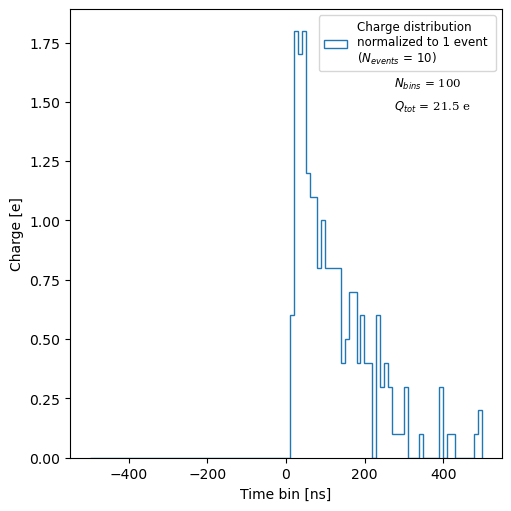

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

n_bins = 100
font_size = 8.5

events, bins, bars = ax.hist(dst.time_bin, n_bins, 
                             weights = dst.charge/n_events,
                             density=False,
                             range=(-1*(dst.time_bin.max()), dst.time_bin.max()),
                             label='Charge distribution \nnormalized to 1 event \n($N_{events}$ = %s)'%(n_events), 
                             histtype='step')

ax.text(0.75, .85, r'$N_{bins}$ = ' + str(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.text(0.75, .8, r'$Q_{tot}$ = ' + str(events.sum()) + ' e', transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size);


In [28]:
events.sum()

21.5

<h2> Add dark counts. </h2>

-  <p style="font-size: 17px; color: black;"> Create the noise at 25ºC </p>

In [29]:
dt = 1e-6 # [s] = 1us

In [30]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [31]:
n_1pe, n_2pe = noise(dark25, x_talk, t0, tf, dt, n_sensors)

print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

We have 166 1pe dark pulses and 12 2pe dark pulses


In [32]:
noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

t_noise = np.concatenate((noise_1pe, noise_2pe))
c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

In [33]:
t_signal = np.asarray(dst.time_bin)
c_signal = np.asarray(dst.charge)

In [34]:
tt = np.concatenate((t_signal, t_noise))
cc = np.concatenate((c_signal/n_events, c_noise))

Total events = 211 = 21 (signal) + 190 (bkg) = 211


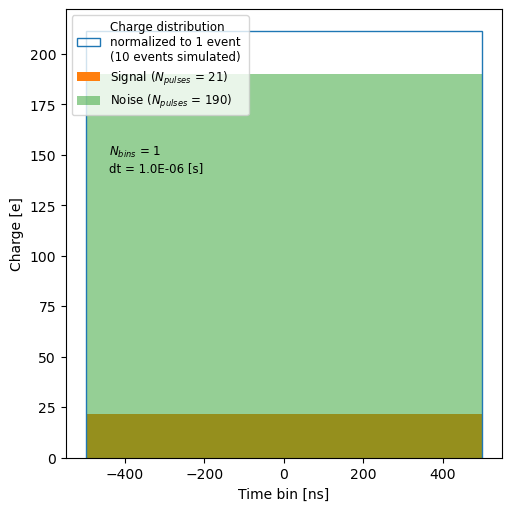

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

font_size = 8.5


t_low = -1*(tt.max())
t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
n_bins = int((t_up - t_low)*1e-9/dt) + 1

# "Data"
events, bins, bars = ax.hist(tt, n_bins, 
                             weights = cc,  # only part of it has to be normalized (signal part)
                             density=False,
                             range=(t_low, t_up),
                             label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                             histtype='step')


# Signal
s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                   weights = c_signal/n_events,
                                   density=False,
                                   range=(t_low, t_up),
                                   label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                   alpha = 1,
                                   histtype='stepfilled')


# Noise
bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                         weights = c_noise, # noise is already normalized
                                         density=False,
                                         range=(t_low, t_up),
                                         label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                         alpha = 0.5,
                                         histtype='stepfilled')


ax.text(0.1, .7, '$N_{bins}$ = %s \ndt = %.1E [s]'%(n_bins, dt), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size, loc = 'upper left');

print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                         s_events.sum(), bkg_events.sum(), 
                                                         events.sum()))


In [36]:
events.mean()

211.50000000000003

Total events = 211 = 21 (signal) + 190 (bkg) = 211
Total events = 211 = 21 (signal) + 190 (bkg) = 211
Total events = 211 = 21 (signal) + 190 (bkg) = 211


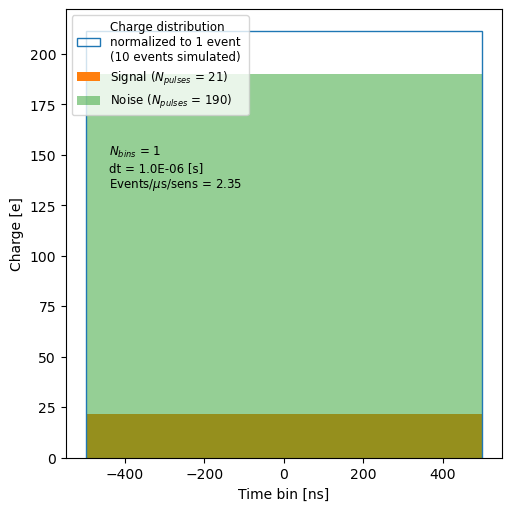

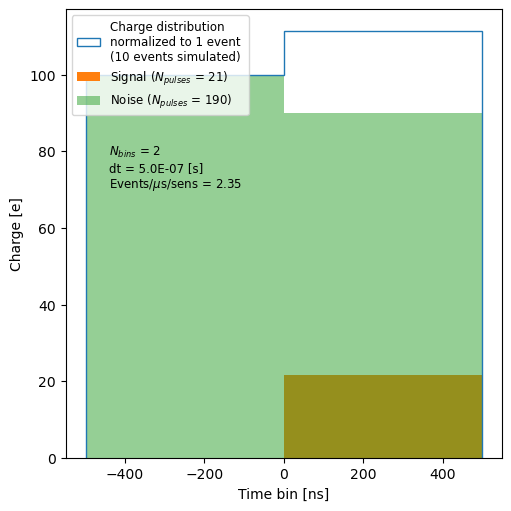

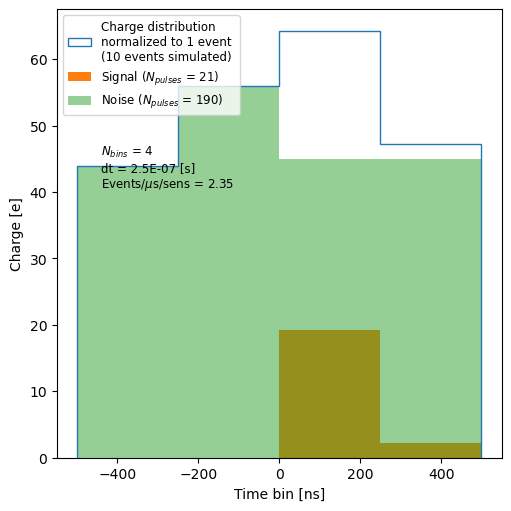

In [37]:
font_size = 8.5

# for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
for dt in [1e-6, 0.5e-6, 0.25e-6]:
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

    t_low = -1*(tt.max())
    t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
    n_bins = int((t_up - t_low)*1e-9/dt) + 1

    # "Data"
    events, bins, bars = ax.hist(tt, n_bins, 
                                 weights = cc,  # only part of it has to be normalized (signal part)
                                 density=False,
                                 range=(t_low, t_up),
                                 label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                 histtype='step')


    # Signal
    s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                       weights = c_signal/n_events,
                                       density=False,
                                       range=(t_low, t_up),
                                       label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                       alpha = 1,
                                       histtype='stepfilled')


    # Noise
    bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                             weights = c_noise, # noise is already normalized
                                             density=False,
                                             range=(t_low, t_up),
                                             label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                             alpha = 0.5,
                                             histtype='stepfilled')


    ax.text(0.1, .7, 
            '$N_{bins}$ = %s \ndt = %.1E [s] \nEvents/$\mu$s/sens = %.2f'%(n_bins, dt, events.mean()*1e-6/dt/n_sensors), 
            transform = ax.transAxes,
            fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
            bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

    ax.set_ylabel('Charge [e]')
    ax.set_xlabel('Time bin [ns]')
    ax.legend(fontsize = font_size, loc = 'upper left');

    print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                             s_events.sum(), bkg_events.sum(), 
                                                             events.sum()))
    


-  <p style="font-size: 17px; color: black;"> Create the noise at different ºC </p>

In [38]:
dt = 1e-6 # [s] = 1us

In [39]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [40]:
# temp = 20

We have 166 1pe dark pulses and 12 2pe dark pulses
Total events = 211 = 21 (signal) + 190 (bkg) = 211
Total events = 211 = 21 (signal) + 190 (bkg) = 211
Total events = 211 = 21 (signal) + 190 (bkg) = 211
We have 120 1pe dark pulses and 9 2pe dark pulses
Total events = 159 = 21 (signal) + 138 (bkg) = 159
Total events = 159 = 21 (signal) + 138 (bkg) = 159
Total events = 159 = 21 (signal) + 138 (bkg) = 159
We have 86 1pe dark pulses and 6 2pe dark pulses
Total events = 119 = 21 (signal) + 98 (bkg) = 119
Total events = 119 = 21 (signal) + 98 (bkg) = 119
Total events = 119 = 21 (signal) + 98 (bkg) = 119


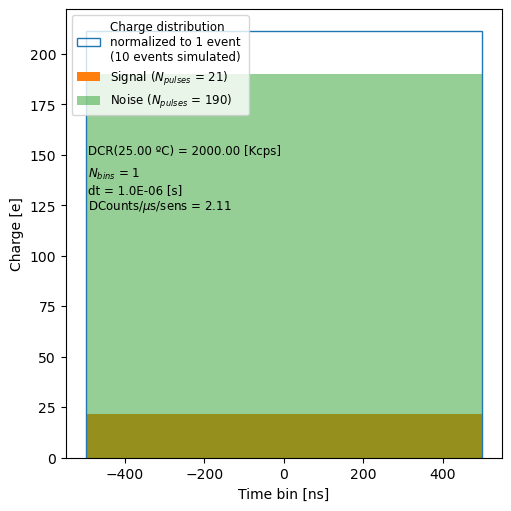

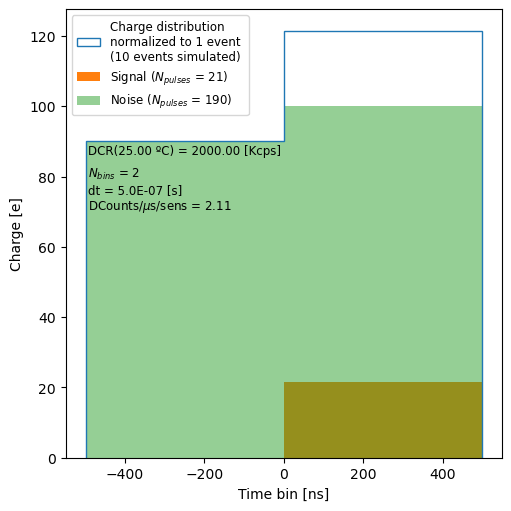

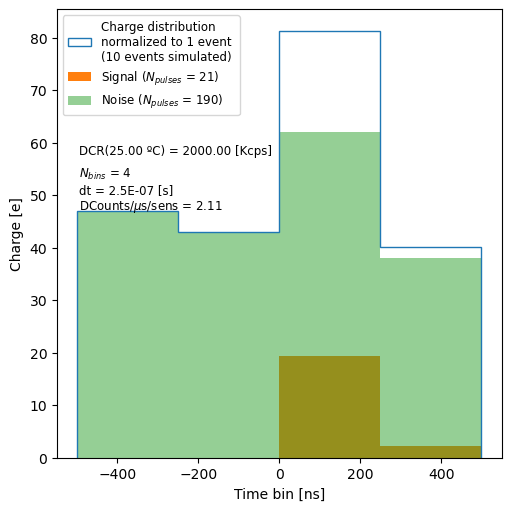

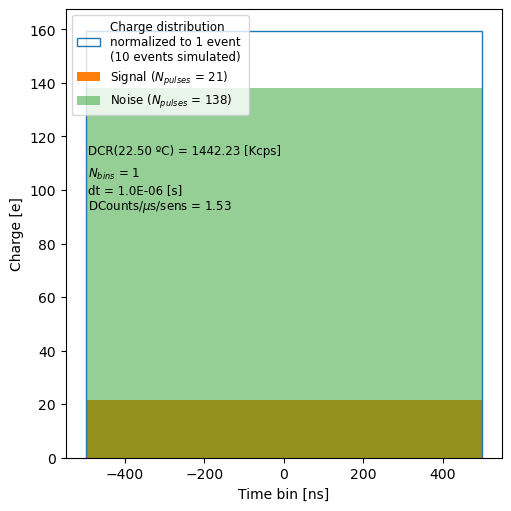

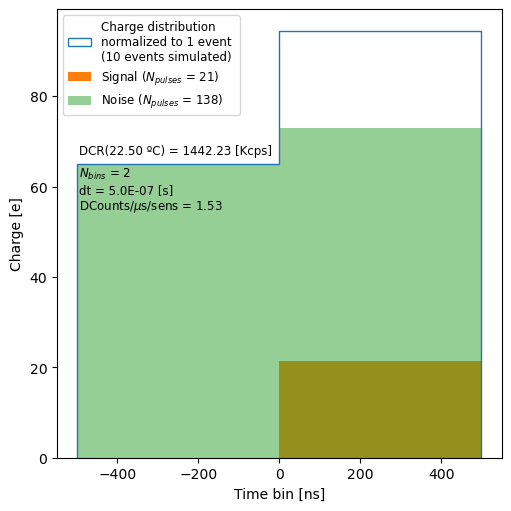

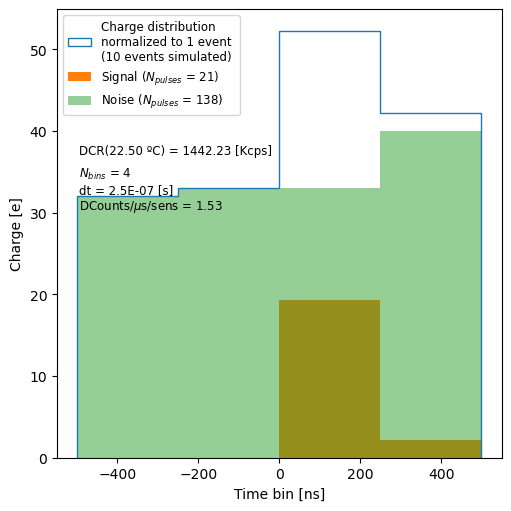

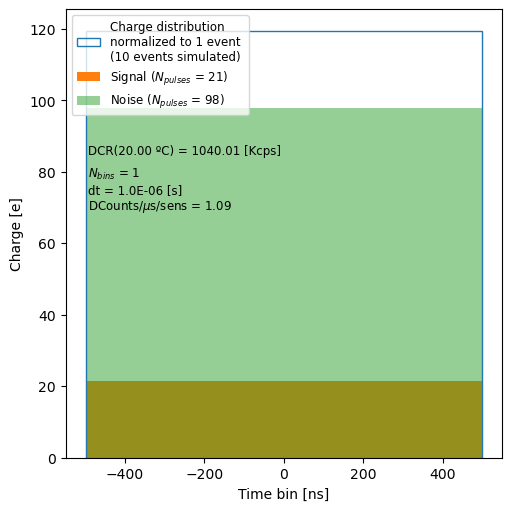

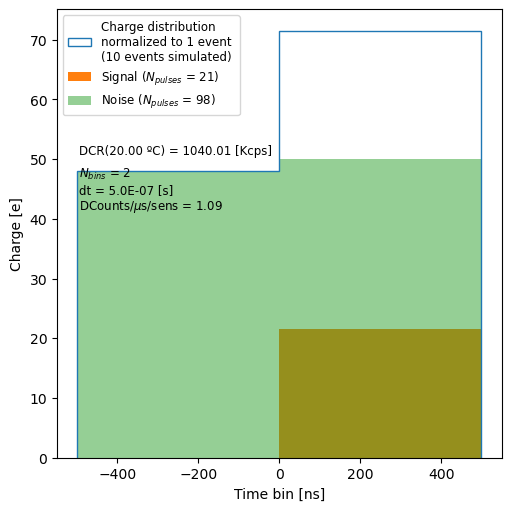

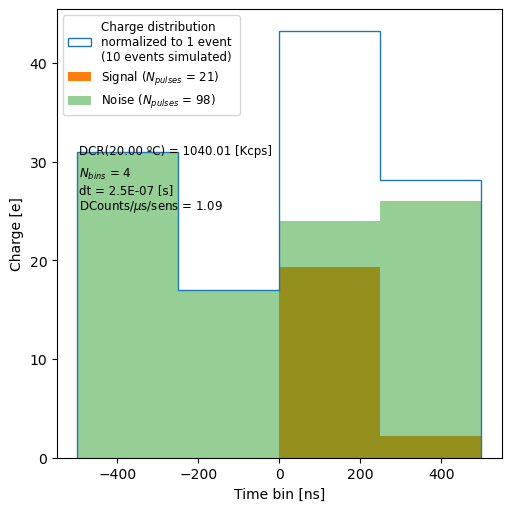

In [41]:
for temp in [25, 22.5, 20]:
    
    DCR = dark_rate(dark25, dT, temp)

    n_1pe, n_2pe = noise(DCR, x_talk, t0, tf, dt, n_sensors)

    print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

    noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
    noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

    t_noise = np.concatenate((noise_1pe, noise_2pe))
    c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

    t_signal = np.asarray(dst.time_bin)
    c_signal = np.asarray(dst.charge)

    tt = np.concatenate((t_signal, t_noise))
    cc = np.concatenate((c_signal/n_events, c_noise))


    font_size = 8.5

    # for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
    for dt in [1e-6, 0.5e-6, 0.25e-6]:

        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

        t_low = -1*(tt.max())
        t_up = tt.max()

    #     dt = (t_up - t_low)*1e-9/n_bins # [s]
        n_bins = int((t_up - t_low)*1e-9/dt) + 1

        # "Data"
        events, bins, bars = ax.hist(tt, n_bins, 
                                     weights = cc,  # only part of it has to be normalized (signal part)
                                     density=False,
                                     range=(t_low, t_up),
                                     label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                     histtype='step')


        # Signal
        s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                           weights = c_signal/n_events,
                                           density=False,
                                           range=(t_low, t_up),
                                           label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                           alpha = 1,
                                           histtype='stepfilled')


        # Noise
        bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                                 weights = c_noise, # noise is already normalized
                                                 density=False,
                                                 range=(t_low, t_up),
                                                 label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                                 alpha = 0.5,
                                                 histtype='stepfilled')


        ax.text(0.05, .7, 
                'DCR(%.2f ºC) = %.2f [Kcps]'%(temp, DCR), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))


        ax.text(0.05, .65, 
                '$N_{bins}$ = %s \ndt = %.1E [s] \nDCounts/$\mu$s/sens = %.2f'%(n_bins, dt, bkg_events.mean()*1e-6/dt/n_sensors), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

        ax.set_ylabel('Charge [e]')
        ax.set_xlabel('Time bin [ns]')
        ax.legend(fontsize = font_size, loc = 'upper left');

        print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                                 s_events.sum(), bkg_events.sum(), 
                                                                 events.sum()))

